# OHCL - Analytics

### Import Library

In [86]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [87]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [88]:
data = dataset.copy()

In [89]:
data["ma_line"] = data["Close"].rolling(20).mean()
data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
data['total_above_ma'] = data['above_ma'].rolling(150).sum()
data['total_below_ma'] = data['below_ma'].rolling(150).sum()
data['trend_diff'] = data['total_above_ma'] - data['total_below_ma']
data['ibs'] = data.apply(
    lambda r: 0 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)

In [90]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
data['Close_9h'] = data['Close']
data['Close_14h'] = data['Close']
data["RSI"] = ta.rsi(data["Close"], length=14)
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h,
        'RSI': bar9h,
        'trend_diff': bar9h,
        'ibs': bar9h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [91]:
day_data = day_data[day_data.Close_9h != day_data.Low]
def get_percent(r):
    return (r['High'] - r['Close_9h']) / (r['Close_9h'] - r['Low'])
day_data['percent'] = day_data.apply(lambda r: get_percent(r), axis=1)

In [92]:
day_data

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,percent
Date,,,,,,,,,,
2018-08-13,943.5,954.2,954.6,942.3,943.1,949.5,NaN,NaN,0.285714,14.375000
2018-08-14,955.5,959.3,961.8,952.1,954.9,960.8,79.515026,NaN,0.250000,2.464286
2018-08-15,958.0,946.6,962.3,946.6,958.7,957.7,54.984480,NaN,0.875000,0.297521
2018-08-16,942.4,947.0,947.3,935.5,942.0,944.0,17.896244,30.0,0.714286,0.815385
2018-08-17,952.2,947.0,954.6,945.0,953.0,947.4,77.237192,-14.0,1.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.2,1292.9,83.969729,20.0,0.500000,1.029412
2024-07-30,1286.1,1292.4,1292.4,1284.2,1285.6,1284.9,20.087542,22.0,0.500000,4.857143
2024-07-31,1292.0,1304.3,1304.3,1291.1,1292.3,1300.5,66.231758,36.0,0.411765,10.000000


In [93]:
day_data['9h_lastclose'] = 1000*(day_data.Close_9h - day_data.Close.shift(1)) / day_data.Open
day_data['9h_last14h'] = 1000*(day_data.Close_9h - day_data.Open) / day_data.Close_14h.shift(1)

In [94]:
day_data.dropna(inplace=True)

In [95]:
day_data['percent'].describe()

count    1480.000000
mean        4.617399
std        12.596726
min         0.000000
25%         0.230369
50%         0.912662
75%         4.000000
max       224.500000
Name: percent, dtype: float64

In [96]:
day_data['percent_group'] = pd.cut(day_data['percent'], 30)
s1 = day_data.groupby(['percent_group'])[['percent']].count()
f1 = s1[['percent']].rename(columns={'percent': 'count'})
day_data.drop(columns=['percent_group'], inplace=True)
f1

,count
percent_group,
"(-0.224, 7.483]",1234
"(7.483, 14.967]",139
"(14.967, 22.45]",45
"(22.45, 29.933]",25
"(29.933, 37.417]",11
"(37.417, 44.9]",7
"(44.9, 52.383]",5
"(52.383, 59.867]",3
"(59.867, 67.35]",2


In [97]:
day_data = day_data[day_data['percent'] < 30]

In [98]:
day_data['9h_lastclose'].describe()

count    1443.000000
mean        0.354582
std         6.960511
min       -93.258996
25%        -1.518902
50%         0.723720
75%         3.067033
max        43.887147
Name: 9h_lastclose, dtype: float64

In [99]:
day_data['9h_last14h'].describe()

count    1443.000000
mean        0.041397
std         1.773211
min       -14.408552
25%        -0.630170
50%         0.069348
75%         0.808026
max        20.968600
Name: 9h_last14h, dtype: float64

In [100]:
day_data['x_group'] = pd.qcut(day_data['9h_lastclose'], 30)
day_data['y_group'] = pd.qcut(day_data['9h_last14h'], 25)

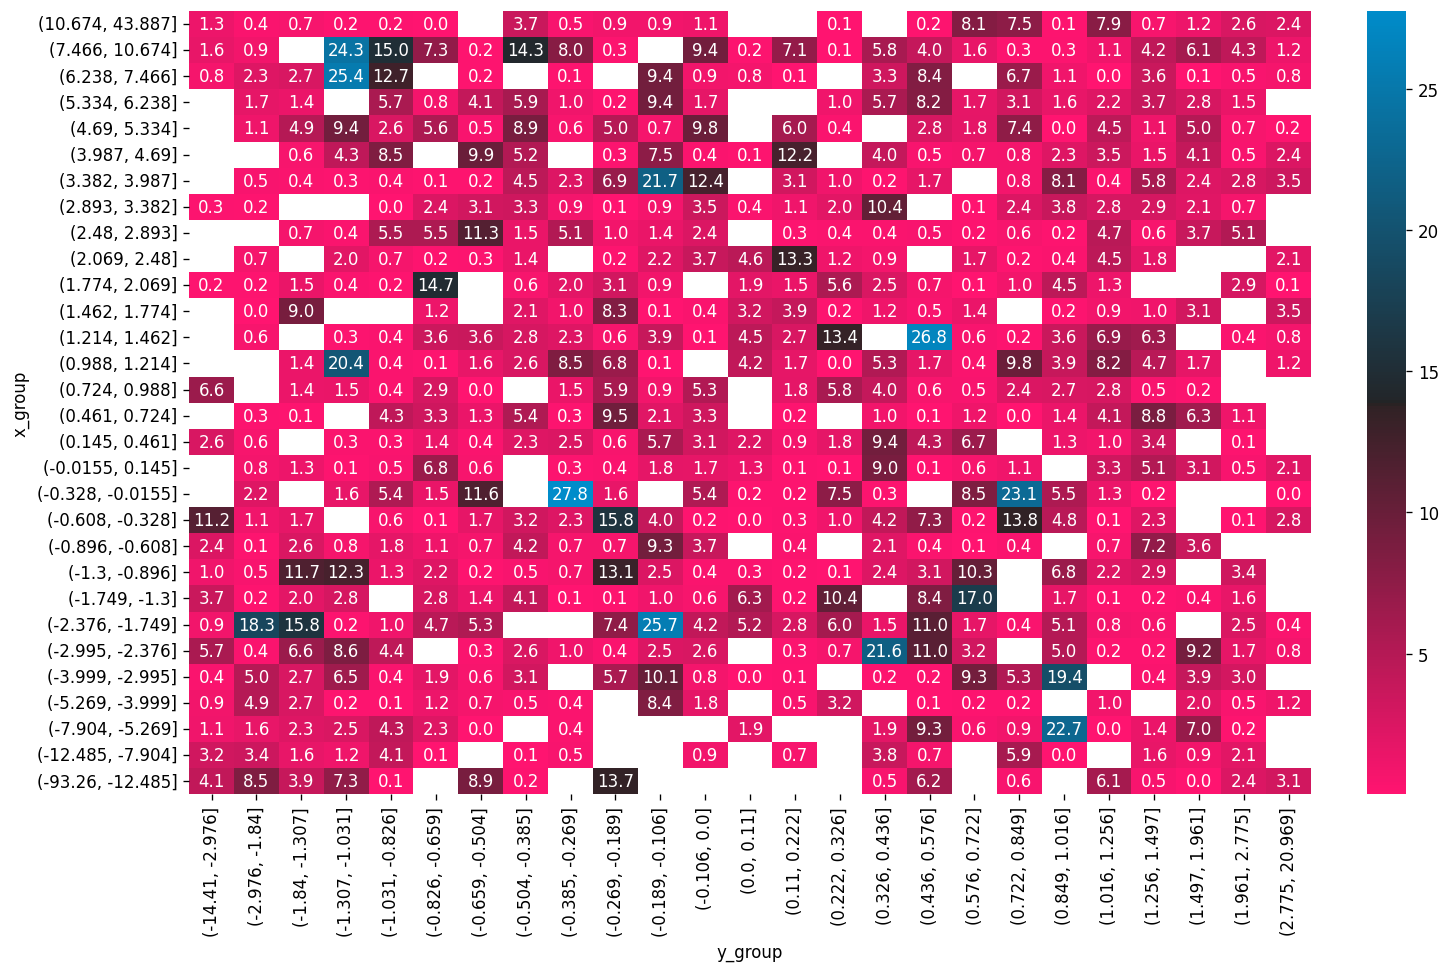

In [101]:
plt.rcParams['figure.figsize'] = [12, 8]
grpd = day_data.groupby(['x_group', 'y_group'])[['percent']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='x_group', columns='y_group', values='percent').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");